In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import datetime
from pyfolio.timeseries import perf_stats
%matplotlib inline

In [2]:
cash = 80000

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/backtests/backtest_2020-06-30_11-59_20180601_20191231.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])
df.contract = df.contract.str.strip('M')
df['contract'] = df['contract'].apply(lambda x: x[:2])
df.contract = df.contract.str.strip()

In [4]:
#df = df.loc[:'20181231']

In [5]:
df.groupby('contract').realizedPNL.sum()

contract
ES    106756.25
GC     15267.32
NQ    159261.42
YM    118549.06
Name: realizedPNL, dtype: float64

In [6]:
df.realizedPNL.sum()

399834.04999999993

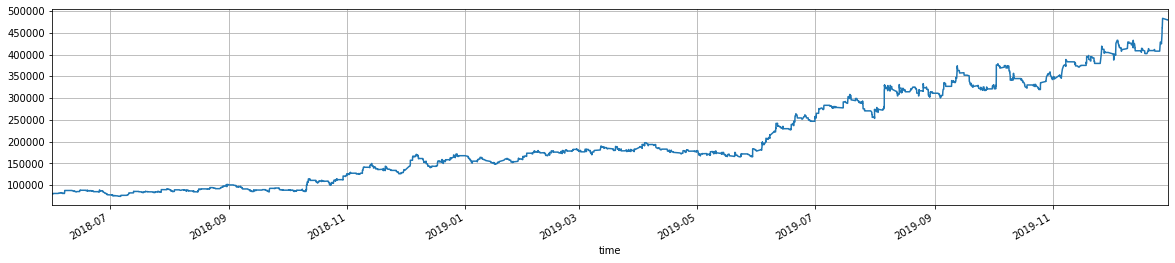

In [7]:
df.cash.plot(figsize=(20,4), grid=True);

In [8]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, aggfunc='sum', columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [10]:
# number of trades
trades = df.groupby('contract').action.count()
trades, trades.sum()

(contract
 ES     642
 GC    1218
 NQ    3554
 YM    1146
 Name: action, dtype: int64, 6560)

In [11]:
# trades per day
days = len(by_contract.resample('B').count().index)
trades/days, trades.sum()/days

(contract
 ES    1.558252
 GC    2.956311
 NQ    8.626214
 YM    2.781553
 Name: action, dtype: float64, 15.922330097087379)

In [12]:
# commission paid
df.groupby('contract').commission.sum()

contract
ES     3722.50
GC     6473.68
NQ    20407.08
YM     6917.94
Name: commission, dtype: float64

In [13]:
df.commission.sum()

37521.2

In [14]:
# per trade stats
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
dfs['total'] = exits
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss','win_ratio', 'EV',
                               'number_of_positions'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    row['average_PNL'] = round(d.realizedPNL.mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0]).realizedPNL.mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0]).realizedPNL.mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['number_of_positions'] = d.realizedPNL.count()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV,number_of_positions
GC,0.37,25.07,1489.87,-839.28,1.78,22.51,609.0
NQ,0.40,89.62,1102.67,-582.90,1.89,91.33,1777.0
YM,0.41,206.89,1906.84,-983.58,1.94,201.49,573.0
ES,0.45,332.57,2354.25,-1291.58,1.82,349.04,321.0
total,0.40,121.90,1449.91,-765.69,1.89,120.55,3280.0


In [15]:
by_contract

contract,ES,GC,NQ,YM,total
time,,,,,
2018-06-01 05:01:30,NaN,0.00,NaN,NaN,0.00
2018-06-01 14:39:00,NaN,501.52,NaN,NaN,501.52
2018-06-01 15:35:30,NaN,NaN,0.00,NaN,0.00
2018-06-01 16:16:30,NaN,NaN,-292.84,NaN,-292.84
2018-06-01 16:22:00,NaN,NaN,0.00,NaN,0.00
...,...,...,...,...,...
2019-12-27 17:27:00,NaN,0.00,NaN,NaN,0.00
2019-12-27 21:50:30,21926.25,NaN,NaN,NaN,21926.25
2019-12-30 11:31:30,NaN,-3957.50,NaN,NaN,-3957.50


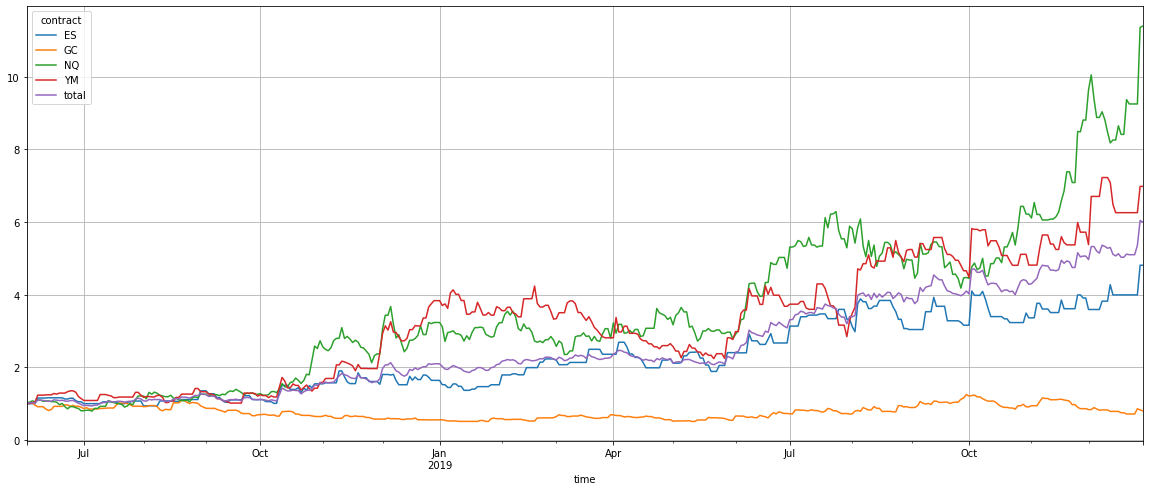

In [16]:
daily = by_contract.resample('B').sum()
total_cumsum = (daily['total'].cumsum() + cash).shift(1).fillna(cash)
daily_non_total = daily[daily.columns.drop('total')] * len(daily.columns.drop('total'))
daily_scaled = daily_non_total.copy()
daily_scaled['total'] = daily['total']
returns = daily.divide(total_cumsum, axis=0)
returns_scaled = daily_scaled.divide(total_cumsum, axis=0)
returns_index = (returns_scaled + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [17]:
# instrument correlations
log_returns = np.log(returns_scaled + 1)
log_returns.corr()

contract,ES,GC,NQ,YM,total
contract,,,,,
ES,1.000000,-0.059550,0.202136,0.406209,0.663945
GC,-0.059550,1.000000,-0.006836,0.026525,0.327630
NQ,0.202136,-0.006836,1.000000,0.252377,0.637712
YM,0.406209,0.026525,0.252377,1.000000,0.736222
total,0.663945,0.327630,0.637712,0.736222,1.000000


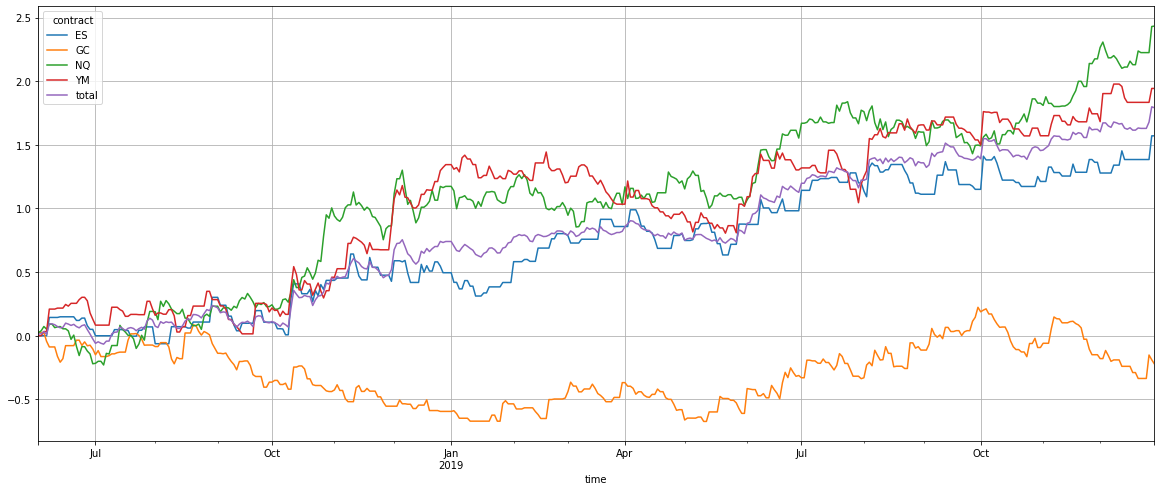

In [18]:
log_returns.cumsum().plot(figsize=(20,8), grid=True);

In [19]:
stats = pd.DataFrame()
for col in daily.columns:
    stats[col] = perf_stats(returns_scaled[col])
stats

,ES,GC,NQ,YM,total
Annual return,1.613739,-0.127126,3.429140,2.282319,1.991333
Cumulative returns,3.810504,-0.199317,10.394124,5.980950,4.997926
Annual volatility,0.867906,0.713058,0.925815,0.944949,0.528002
Sharpe ratio,1.510757,0.146483,2.057783,1.698487,2.332261
Calmar ratio,5.404198,-0.239004,9.524824,4.838580,11.411646
Stability,0.932981,0.027485,0.904532,0.838986,0.962948
Max drawdown,-0.298608,-0.531898,-0.360021,-0.471692,-0.174500
Omega ratio,1.504548,1.032529,1.462613,1.473621,1.559534
Sortino ratio,3.218333,0.276701,3.730613,3.671122,5.083514
Skew,2.232005,1.993729,0.907608,1.983970,1.841523


In [20]:
#non-scaled returns
stats_non_scaled = pd.DataFrame()
for col in daily.columns:
    stats_non_scaled[col] = perf_stats(returns[col])
stats_non_scaled

,ES,GC,NQ,YM,total
Annual return,0.356105,0.010547,0.567422,0.453097,1.991333
Cumulative returns,0.645466,0.017300,1.085036,0.842208,4.997926
Annual volatility,0.216977,0.178265,0.231454,0.236237,0.528002
Sharpe ratio,1.510757,0.146483,2.057783,1.698487,2.332261
Calmar ratio,4.475235,0.064836,6.042474,3.320006,11.411646
Stability,0.955197,0.202345,0.933304,0.886995,0.962948
Max drawdown,-0.079572,-0.162666,-0.093906,-0.136475,-0.174500
Omega ratio,1.504548,1.032529,1.462613,1.473621,1.559534
Sortino ratio,3.218333,0.276701,3.730613,3.671122,5.083514
Skew,2.232005,1.993729,0.907608,1.983970,1.841523


In [21]:
# monthly returns in percent
log_r = np.log(returns + 1)
monthly_log_returns = log_r.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns)-1
monthly_returns = round(monthly_returns, 4) * 100
monthly_returns

contract,ES,GC,NQ,YM,total
time,,,,,
2018-06-30,1.52,-2.26,-5.03,3.78,-2.48
2018-07-31,0.57,0.96,11.70,2.41,15.96
2018-08-31,6.74,0.00,1.59,2.38,11.18
2018-09-30,-4.41,-6.18,0.08,-1.69,-11.97
2018-10-31,10.03,-1.42,22.90,8.43,42.25
2018-11-30,0.72,-2.57,-2.93,12.07,6.73
2018-12-31,2.47,-0.89,9.85,13.34,24.82
2019-01-31,-1.68,1.76,0.49,-0.94,-0.49
2019-02-28,10.55,1.41,-3.63,-1.72,6.40


In [22]:
monthly_returns.total.mean(), monthly_returns.total.median()

(10.649473684210525, 6.7299999999999995)

In [23]:
monthly_returns.sort_values('total', ascending = False).total

time
2018-10-31    42.25
2019-06-30    38.28
2018-12-31    24.82
2019-12-31    18.49
2019-11-30    18.17
2018-07-31    15.96
2019-08-31    14.52
2018-08-31    11.18
2019-07-31    10.12
2018-11-30     6.73
2019-02-28     6.40
2019-09-30     5.37
2019-10-31     4.47
2019-03-31     2.31
2019-05-31    -0.45
2019-01-31    -0.49
2019-04-30    -1.34
2018-06-30    -2.48
2018-09-30   -11.97
Name: total, dtype: float64

In [24]:
# total returns by contract in percent
round(np.exp(monthly_log_returns.sum())-1, 2)* 100

contract
ES        65.0
GC         2.0
NQ       109.0
YM        84.0
total    500.0
dtype: float64

In [25]:
df.sort_values('realizedPNL', ascending=False)[['contract', 'action', 'price', 'realizedPNL']]

,contract,action,price,realizedPNL
time,,,,
2019-12-27 15:12:00,NQ,SELL,8829.25,23865.40
2019-10-02 21:00:00,ES,BUY,2893.75,23245.60
2019-10-02 20:45:30,YM,BUY,26063.00,21355.60
2019-12-27 21:50:30,ES,SELL,3235.50,20774.70
2019-12-26 17:30:30,GC,SELL,1511.80,19881.28
...,...,...,...,...
2019-11-19 16:04:00,ES,SELL,3118.75,-5900.40
2019-12-13 16:30:30,YM,SELL,28180.00,-6292.00
2019-12-12 14:03:00,YM,SELL,27873.00,-6410.40


In [26]:
daily.sort_values('total', ascending=False)

contract,ES,GC,NQ,YM,total
time,,,,,
2019-10-02,23908.72,1076.88,5730.96,24096.64,54813.20
2019-12-27,21926.25,-3953.42,24414.58,12384.86,54772.27
2019-08-05,17722.12,1535.20,5473.00,19781.92,44512.24
2019-11-26,9991.30,-7154.50,18830.24,10886.36,32553.40
2019-09-05,0.00,10076.88,13714.26,5625.64,29416.78
...,...,...,...,...,...
2019-07-30,-5097.04,0.00,-3032.44,-6785.60,-14915.08
2019-12-13,-6984.64,0.00,1030.48,-9110.16,-15064.32
2019-10-10,-5948.96,-2399.12,128.06,-6865.78,-15085.80
